In [ ]:
# Imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)


Libraries imported successfully


In [2]:
# Load dataset
dataset = pd.read_csv("dataset.csv")


In [3]:
# Define columns to impute with 0
columns_to_impute = [
    # Google spend
    'GOOGLE_PAID_SEARCH_SPEND','GOOGLE_SHOPPING_SPEND','GOOGLE_PMAX_SPEND','GOOGLE_DISPLAY_SPEND','GOOGLE_VIDEO_SPEND',
    # Google impressions
    'GOOGLE_PAID_SEARCH_IMPRESSIONS','GOOGLE_SHOPPING_IMPRESSIONS','GOOGLE_PMAX_IMPRESSIONS','GOOGLE_DISPLAY_IMPRESSIONS','GOOGLE_VIDEO_IMPRESSIONS',
    # Google clicks
    'GOOGLE_PAID_SEARCH_CLICKS','GOOGLE_SHOPPING_CLICKS','GOOGLE_PMAX_CLICKS','GOOGLE_DISPLAY_CLICKS','GOOGLE_VIDEO_CLICKS',
    # Meta spend
    'META_FACEBOOK_SPEND','META_INSTAGRAM_SPEND','META_OTHER_SPEND',
    # Meta impressions
    'META_FACEBOOK_IMPRESSIONS','META_INSTAGRAM_IMPRESSIONS','META_OTHER_IMPRESSIONS',
    # Meta clicks
    'META_FACEBOOK_CLICKS','META_INSTAGRAM_CLICKS','META_OTHER_CLICKS',
    # TikTok
    'TIKTOK_SPEND','TIKTOK_IMPRESSIONS','TIKTOK_CLICKS',
    # Other clicks
    'DIRECT_CLICKS','BRANDED_SEARCH_CLICKS','ORGANIC_SEARCH_CLICKS','EMAIL_CLICKS','REFERRAL_CLICKS','ALL_OTHER_CLICKS'
]

# Create a copy and fill NaNs with 0
dataset_imputed = dataset.copy()
dataset_imputed[columns_to_impute] = dataset_imputed[columns_to_impute].fillna(0)


In [4]:
# Feature engineering - create aggregate features
new_dataset = dataset_imputed.copy()

# Click columns
click_columns = ['GOOGLE_PAID_SEARCH_CLICKS','GOOGLE_SHOPPING_CLICKS','GOOGLE_PMAX_CLICKS','GOOGLE_DISPLAY_CLICKS','GOOGLE_VIDEO_CLICKS',
                'META_FACEBOOK_CLICKS','META_INSTAGRAM_CLICKS','META_OTHER_CLICKS','TIKTOK_CLICKS',
                'DIRECT_CLICKS','BRANDED_SEARCH_CLICKS','ORGANIC_SEARCH_CLICKS','EMAIL_CLICKS','REFERRAL_CLICKS','ALL_OTHER_CLICKS']

# Total clicks
new_dataset['TOTAL_CLICKS'] = new_dataset[click_columns].sum(axis=1)

# Impression columns
impression_columns = ['GOOGLE_PAID_SEARCH_IMPRESSIONS','GOOGLE_SHOPPING_IMPRESSIONS','GOOGLE_PMAX_IMPRESSIONS','GOOGLE_DISPLAY_IMPRESSIONS','GOOGLE_VIDEO_IMPRESSIONS',
                      'META_FACEBOOK_IMPRESSIONS','META_INSTAGRAM_IMPRESSIONS','META_OTHER_IMPRESSIONS',
                      'TIKTOK_IMPRESSIONS']

# Total impressions
new_dataset['TOTAL_IMPRESSIONS'] = new_dataset[impression_columns].sum(axis=1)

# Spend columns
spend_columns = ['GOOGLE_PAID_SEARCH_SPEND','GOOGLE_SHOPPING_SPEND','GOOGLE_PMAX_SPEND','GOOGLE_DISPLAY_SPEND','GOOGLE_VIDEO_SPEND',
                'META_FACEBOOK_SPEND','META_INSTAGRAM_SPEND','META_OTHER_SPEND',
                'TIKTOK_SPEND']

# Total spend
new_dataset['TOTAL_SPEND'] = new_dataset[spend_columns].sum(axis=1)

# Create target variables
new_dataset["ROI"] = new_dataset["ALL_PURCHASES"] / new_dataset["TOTAL_SPEND"]
new_dataset["ROI_RETURNING"] = (new_dataset["ALL_PURCHASES"] - new_dataset["FIRST_PURCHASES"]) / new_dataset["TOTAL_SPEND"]
new_dataset["ROI_FIRST"] = new_dataset["FIRST_PURCHASES"] / new_dataset["TOTAL_SPEND"]
new_dataset["CTR"] = new_dataset["TOTAL_CLICKS"] / new_dataset["TOTAL_IMPRESSIONS"]
new_dataset["CP_DOLLAR"] = new_dataset["TOTAL_SPEND"] / new_dataset["TOTAL_CLICKS"]

# Handle inf and NaN values
new_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
new_dataset.fillna(0, inplace=True)


In [5]:
# Remove outliers using 0.5th and 99.5th percentiles
target_variables = ['ROI_FIRST', 'ROI', 'ROI_RETURNING', 'CTR', 'CP_DOLLAR']

# Calculate percentiles
lower_percentile = new_dataset[target_variables].quantile(0.005)
upper_percentile = new_dataset[target_variables].quantile(0.995)

# Filter out outliers and zeros
mask = True
for var in target_variables:
    mask = mask & (new_dataset[var] >= lower_percentile[var]) & (new_dataset[var] <= upper_percentile[var]) & (new_dataset[var] != 0)

new_dataset = new_dataset[mask]
new_dataset.describe()

,FIRST_PURCHASES,FIRST_PURCHASES_UNITS,FIRST_PURCHASES_ORIGINAL_PRICE,FIRST_PURCHASES_GROSS_DISCOUNT,ALL_PURCHASES,ALL_PURCHASES_UNITS,ALL_PURCHASES_ORIGINAL_PRICE,ALL_PURCHASES_GROSS_DISCOUNT,GOOGLE_PAID_SEARCH_SPEND,GOOGLE_SHOPPING_SPEND,GOOGLE_PMAX_SPEND,GOOGLE_DISPLAY_SPEND,GOOGLE_VIDEO_SPEND,META_FACEBOOK_SPEND,META_INSTAGRAM_SPEND,META_OTHER_SPEND,TIKTOK_SPEND,GOOGLE_PAID_SEARCH_CLICKS,GOOGLE_SHOPPING_CLICKS,GOOGLE_PMAX_CLICKS,GOOGLE_DISPLAY_CLICKS,GOOGLE_VIDEO_CLICKS,META_FACEBOOK_CLICKS,META_INSTAGRAM_CLICKS,META_OTHER_CLICKS,TIKTOK_CLICKS,GOOGLE_PAID_SEARCH_IMPRESSIONS,GOOGLE_SHOPPING_IMPRESSIONS,GOOGLE_PMAX_IMPRESSIONS,GOOGLE_DISPLAY_IMPRESSIONS,GOOGLE_VIDEO_IMPRESSIONS,META_FACEBOOK_IMPRESSIONS,META_INSTAGRAM_IMPRESSIONS,META_OTHER_IMPRESSIONS,TIKTOK_IMPRESSIONS,DIRECT_CLICKS,BRANDED_SEARCH_CLICKS,ORGANIC_SEARCH_CLICKS,EMAIL_CLICKS,REFERRAL_CLICKS,ALL_OTHER_CLICKS,TOTAL_CLICKS,TOTAL_IMPRESSIONS,TOTAL_SPEND,ROI,ROI_RETURNING,ROI_FIRST,CTR,CP_DOLLAR
count,119542.000000,1.195420e+05,1.195420e+05,1.195420e+05,119542.000000,1.195420e+05,1.195420e+05,1.195420e+05,119542.000000,119542.000000,119542.000000,119542.000000,119542.000000,1.195420e+05,1.195420e+05,119542.000000,119542.000000,119542.000000,119542.000000,119542.000000,119542.000000,119542.000000,119542.000000,119542.000000,119542.000000,119542.000000,1.195420e+05,1.195420e+05,1.195420e+05,1.195420e+05,1.195420e+05,1.195420e+05,1.195420e+05,1.195420e+05,119542.000000,119542.000000,119542.000000,119542.000000,119542.000000,119542.000000,119542.000000,119542.000000,1.195420e+05,1.195420e+05,119542.000000,119542.000000,119542.000000,119542.000000,119542.000000
mean,88.810000,5.594791e+02,3.890573e+04,3.757189e+03,127.656765,1.400971e+03,6.842782e+04,7.744275e+03,213.784084,521.849663,510.243403,21.397509,52.606216,1.581059e+03,7.532960e+02,2.192988,10.890987,186.592838,686.457663,521.104649,15.397768,8.763815,1055.342683,163.122409,0.651311,10.726339,3.525443e+03,9.729045e+04,5.046365e+04,2.817560e+03,2.066046e+03,5.964448e+04,1.339816e+04,3.316160e+02,1243.789471,457.500987,220.029262,560.056775,346.404101,248.834677,644.433613,5125.418890,2.307812e+05,3.667320e+03,0.153114,0.049431,0.103683,0.037473,0.556161
std,145.293247,5.184780e+03,3.909196e+05,4.489713e+04,218.861247,1.323072e+04,7.713259e+05,1.060637e+05,1155.452310,1881.302859,3081.343230,383.649471,960.590685,2.770459e+04,1.569531e+04,46.458414,107.870616,471.050076,1544.103508,1539.268675,165.815550,136.276535,2354.593288,707.368487,5.748566,102.630184,1.220256e+04,2.226354e+05,1.319677e+05,3.032823e+04,2.182407e+04,1.433617e+05,6.052744e+04,1.294568e+04,12336.575973,961.768434,575.847216,1140.509233,938.887495,818.799964,1689.919027,7472.508442,3.333843e+05,4.226639e+04,0.323650,0.139654,0.220069,0.086807,1.949362
min,1.000000,1.000000e+00,1.000000e+01,0.000000e+00,2.000000,2.000000e+00,2.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.000000e+00,6.500000e-01,0.000057,0.000030,0.000025,0.000367,0.003421
25%,16.000000,2.900000e+01,1.846000e+03,4.673929e+01,23.000000,4.100000e+01,2.836770e+03,8.131553e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,12.000000,0.000000,81.000000,13.000000,14.000000,53.000000,996.000000,3.935200e+04,2.824675e+02,0.040831,0.008859,0.028179,0.015974,0.186206
50%,38.000000,7.800000e+01,5.648280e+03,2.060000e+02,55.000000,1.280000e+02,8.211280e+03,3.365800e+02,30.410000,44.290000,0.000000,0.000000,0.000000,5.946000e+01,0.000000e+

In [6]:
# Prepare features for modeling
# Drop original target columns and outcome columns that wouldn't be known beforehand
new_dataset = new_dataset.drop(columns=['FIRST_PURCHASES', 'ALL_PURCHASES'])

# Drop click columns (outcome variables)
new_dataset = new_dataset.drop(columns=click_columns)

# Drop purchase outcome columns
purchase_outcome_columns = ['FIRST_PURCHASES_UNITS', 'FIRST_PURCHASES_ORIGINAL_PRICE', 'FIRST_PURCHASES_GROSS_DISCOUNT',
                            'ALL_PURCHASES_UNITS', 'ALL_PURCHASES_ORIGINAL_PRICE', 'ALL_PURCHASES_GROSS_DISCOUNT',
                            'TOTAL_CLICKS']
new_dataset = new_dataset.drop(columns=purchase_outcome_columns)

# Select only numeric columns for modeling
model_dataset = new_dataset.select_dtypes(include=[np.number])


In [7]:
# Sample 12,000 random entries
sample_dataset = model_dataset.sample(n=12000, random_state=42)

# Split into features and targets
X = sample_dataset.drop(columns=target_variables)
y = sample_dataset[target_variables]

# Split into train (10,000) and test (2,000)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=2000, train_size=10000, random_state=42
)


In [8]:
# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [20, 30, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', None]
}

# Define K-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)


In [9]:
# Dictionary to store models and results
models = {}
results = {}

# Train a model for each target variable
for target in target_variables: 
    # Initialize Random Forest
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    
    # GridSearchCV
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=kfold,
        scoring='neg_mean_squared_error',
        verbose=1,
        n_jobs=-1
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train[target])
    
    # Store the best model
    models[target] = grid_search.best_estimator_
    
    # Store results
    results[target] = {
        'best_params': grid_search.best_params_,
        'best_score': -grid_search.best_score_,
        'cv_results': grid_search.cv_results_
    }
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best CV MSE: {-grid_search.best_score_}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best CV MSE: 0.017362110242524917
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best CV MSE: 0.032451281716405656
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV MSE: 0.006914046289975941
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best CV MSE: 0.0033243136975412875
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: {'max_depth': None, 'ma

In [10]:
# Evaluate each model on test set
evaluation_results = {}

for target in target_variables:
    # Make predictions
    y_pred = models[target].predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test[target], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)
    
    # Store results
    evaluation_results[target] = {
        'predictions': y_pred,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }


In [11]:
# Create summary table
summary_df = pd.DataFrame({
    'Target': target_variables,
    'MSE': [evaluation_results[t]['mse'] for t in target_variables],
    'RMSE': [evaluation_results[t]['rmse'] for t in target_variables],
    'MAE': [evaluation_results[t]['mae'] for t in target_variables],
    'R² Score': [evaluation_results[t]['r2'] for t in target_variables]
})

print(summary_df.to_string(index=False))


       Target      MSE     RMSE      MAE  R² Score
    ROI_FIRST 0.016912 0.130047 0.043099  0.587875
          ROI 0.033141 0.182045 0.063908  0.638163
ROI_RETURNING 0.008780 0.093701 0.029244  0.505667
          CTR 0.003361 0.057977 0.014164  0.543500
    CP_DOLLAR 0.234358 0.484106 0.173231  0.921879


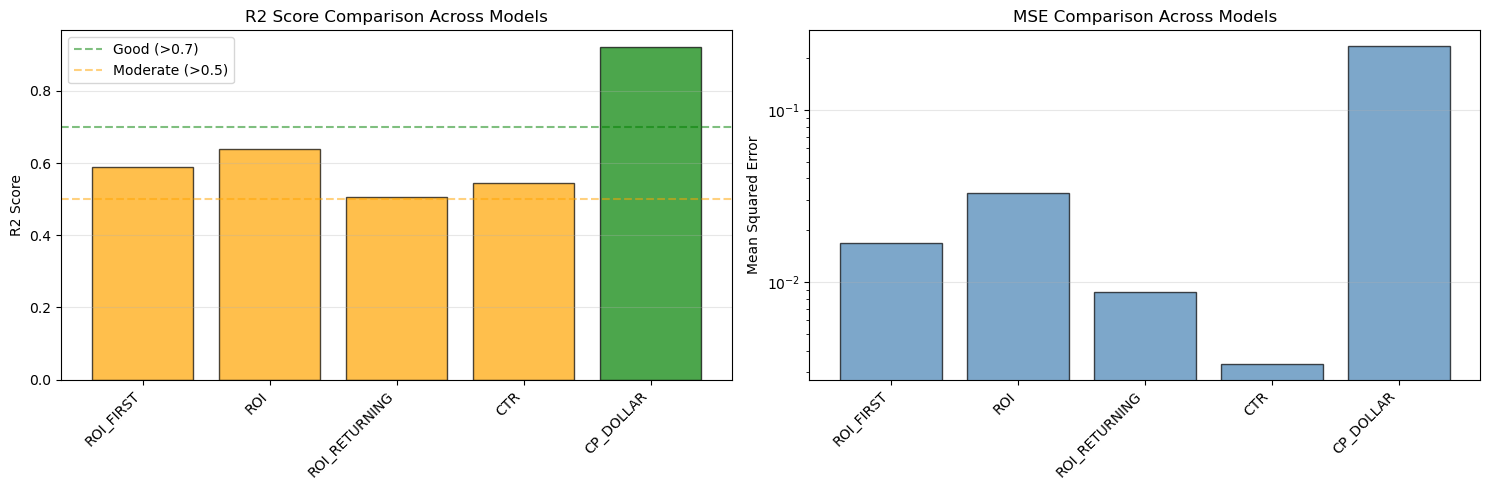

In [12]:
# Plot R2 scores and MSE comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# R2 Score comparison
r2_scores = [evaluation_results[t]['r2'] for t in target_variables]
colors = ['green' if r2 > 0.7 else 'orange' if r2 > 0.5 else 'red' for r2 in r2_scores]

axes[0].bar(range(len(target_variables)), r2_scores, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_xticks(range(len(target_variables)))
axes[0].set_xticklabels(target_variables, rotation=45, ha='right')
axes[0].set_ylabel('R2 Score')
axes[0].set_title('R2 Score Comparison Across Models')
axes[0].axhline(y=0.7, color='green', linestyle='--', alpha=0.5, label='Good (>0.7)')
axes[0].axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, label='Moderate (>0.5)')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# MSE comparison (log scale for better visualization)
mse_scores = [evaluation_results[t]['mse'] for t in target_variables]
axes[1].bar(range(len(target_variables)), mse_scores, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].set_xticks(range(len(target_variables)))
axes[1].set_xticklabels(target_variables, rotation=45, ha='right')
axes[1].set_ylabel('Mean Squared Error')
axes[1].set_title('MSE Comparison Across Models')
axes[1].set_yscale('log')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


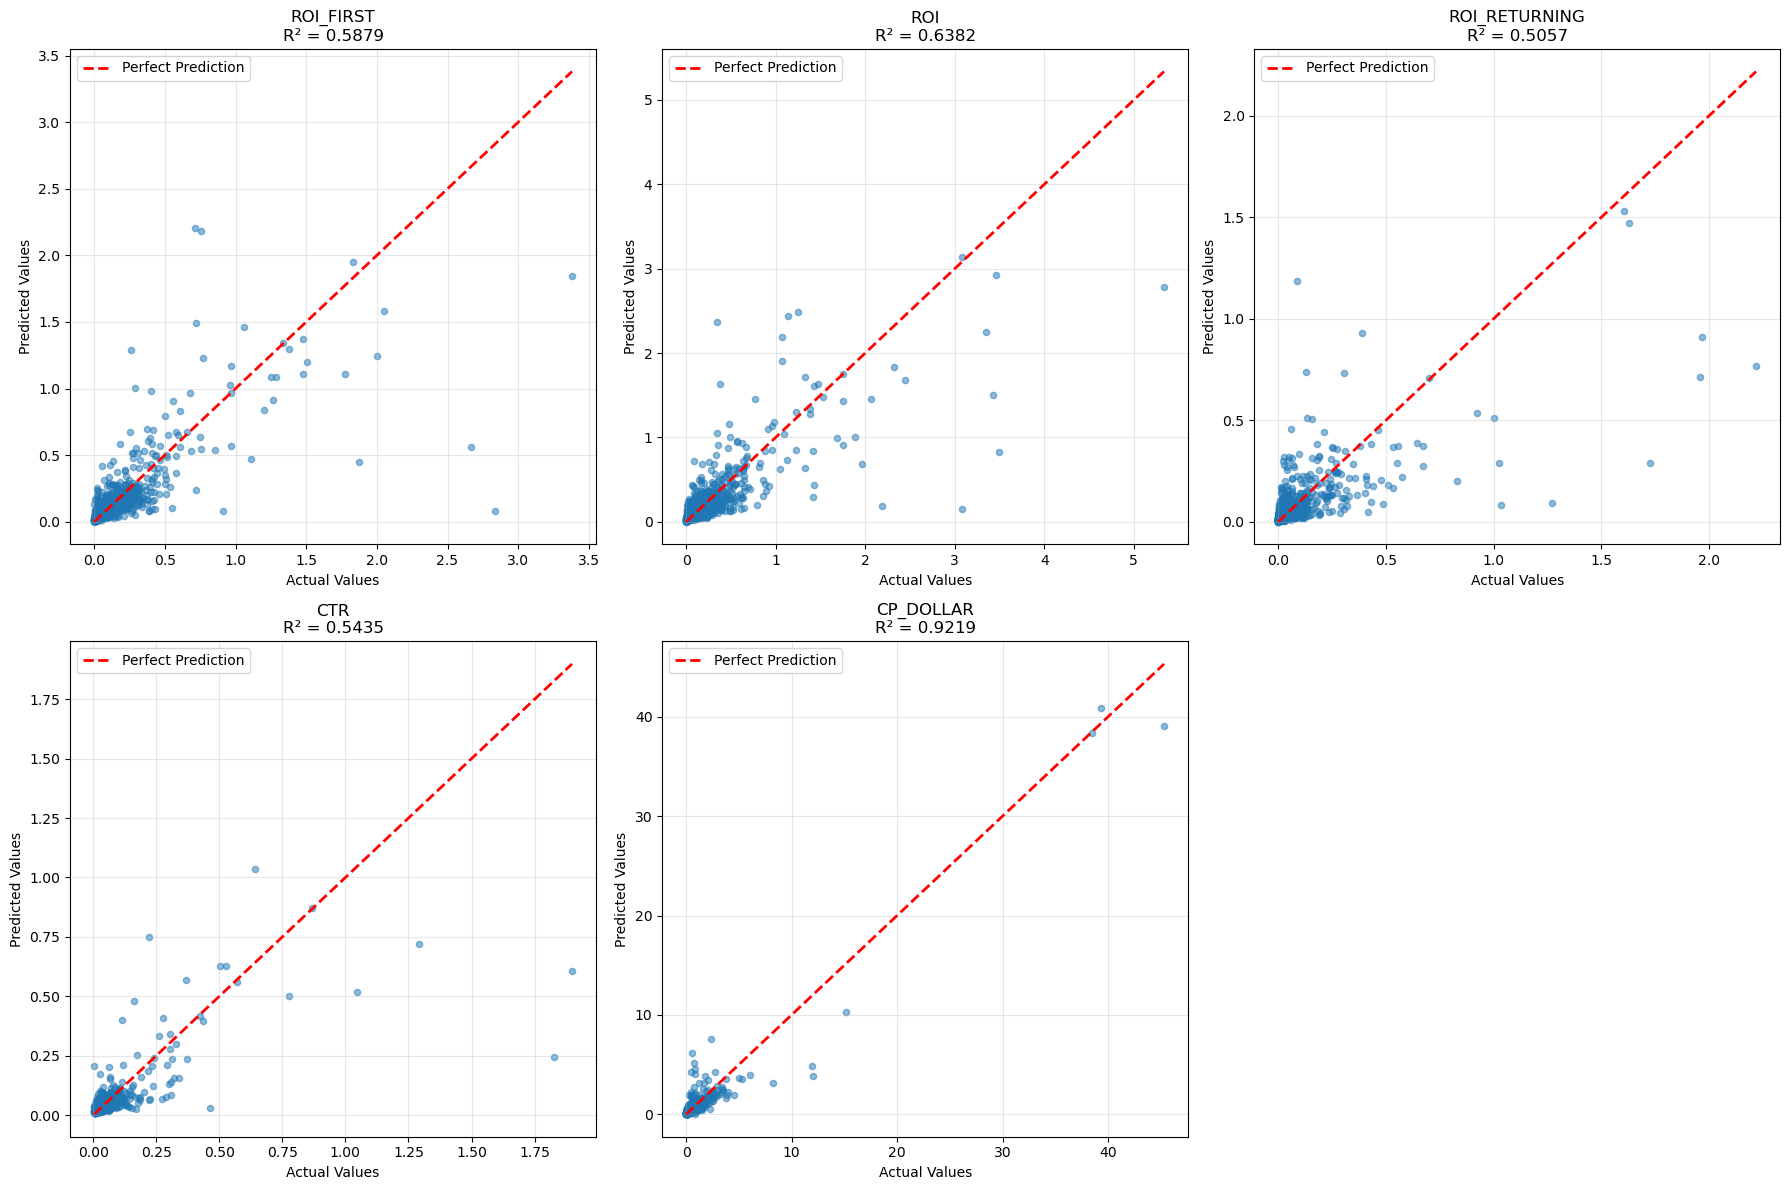

In [13]:
# Actual vs Predicted plots for each target
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, target in enumerate(target_variables):
    y_true = y_test[target]
    y_pred = evaluation_results[target]['predictions']
    r2 = evaluation_results[target]['r2']
    
    # Scatter plot
    axes[idx].scatter(y_true, y_pred, alpha=0.5, s=20)
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    axes[idx].set_xlabel('Actual Values')
    axes[idx].set_ylabel('Predicted Values')
    axes[idx].set_title(f'{target}\nR² = {r2:.4f}')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()


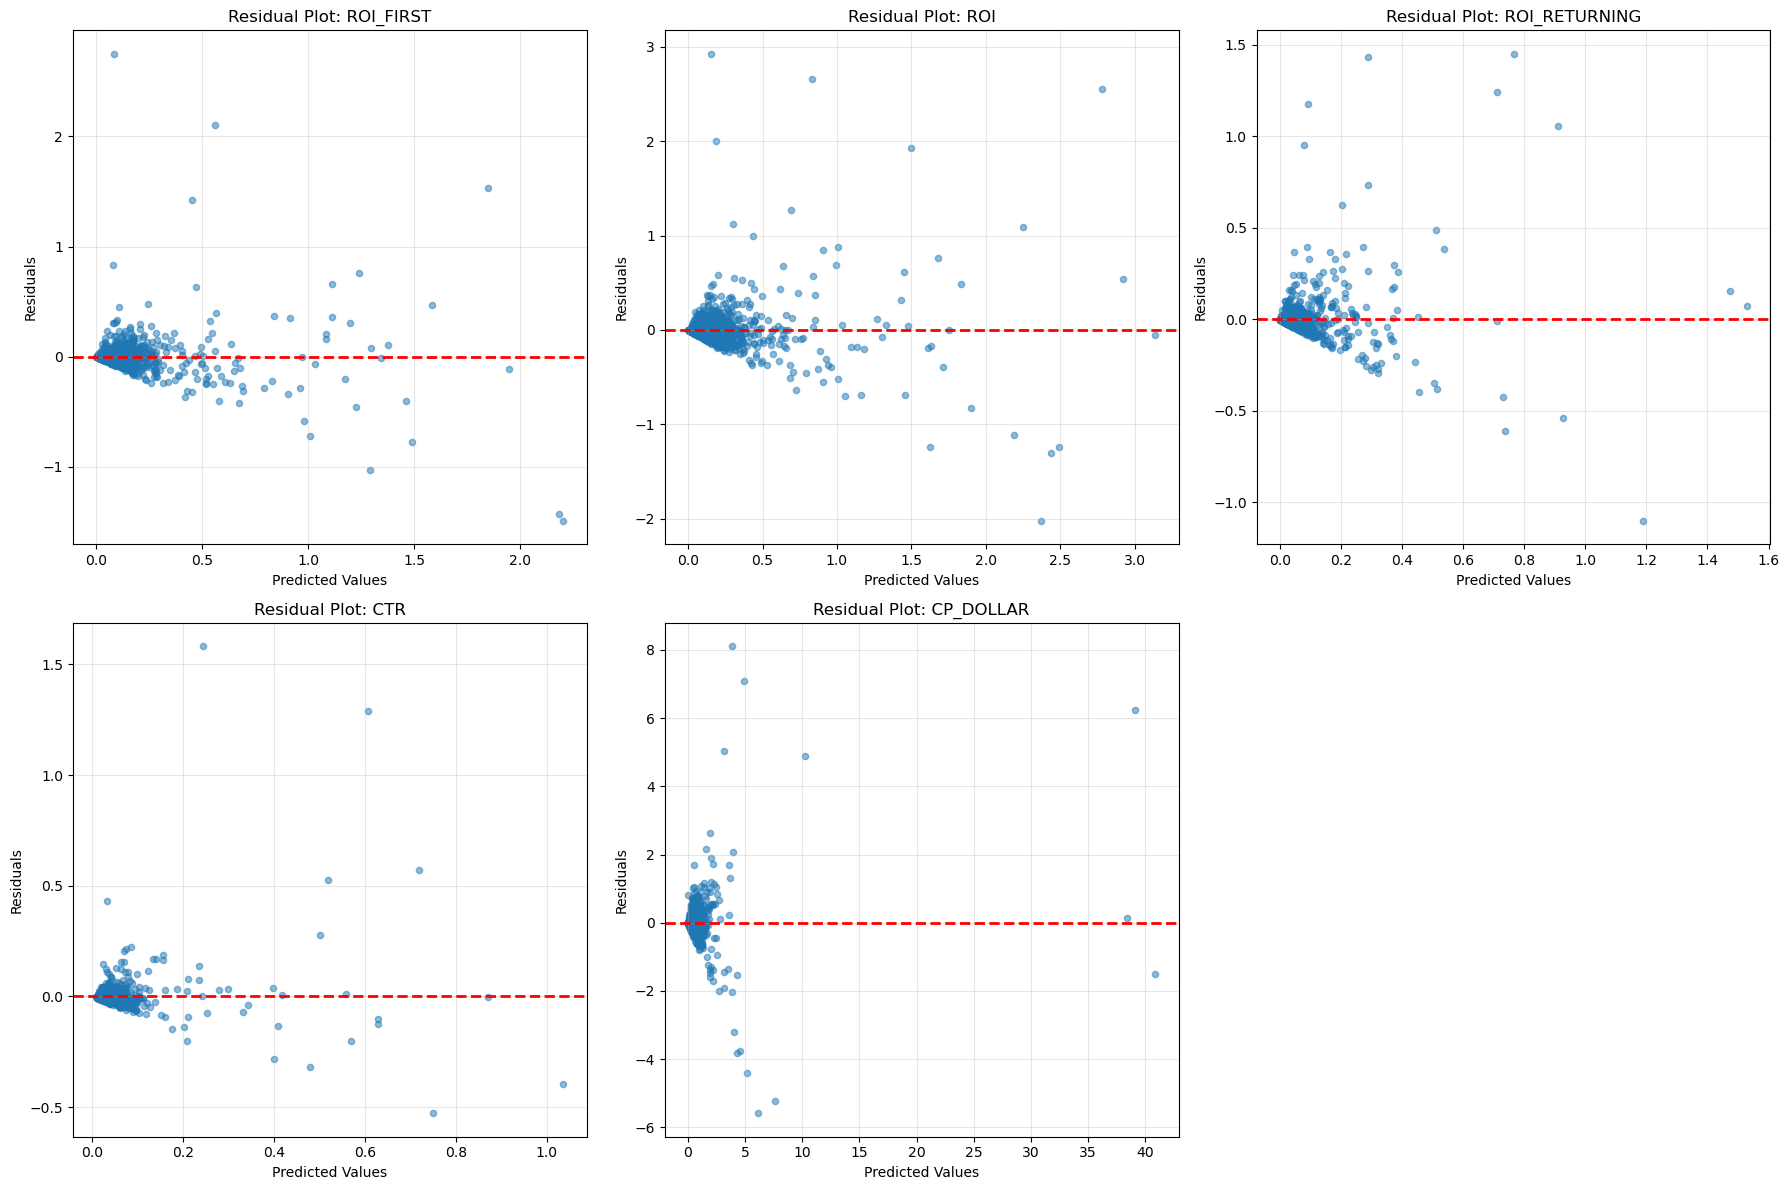

In [14]:
# Residual plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, target in enumerate(target_variables):
    y_true = y_test[target]
    y_pred = evaluation_results[target]['predictions']
    residuals = y_true - y_pred
    
    # Residual plot
    axes[idx].scatter(y_pred, residuals, alpha=0.5, s=20)
    axes[idx].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[idx].set_xlabel('Predicted Values')
    axes[idx].set_ylabel('Residuals')
    axes[idx].set_title(f'Residual Plot: {target}')
    axes[idx].grid(alpha=0.3)

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()


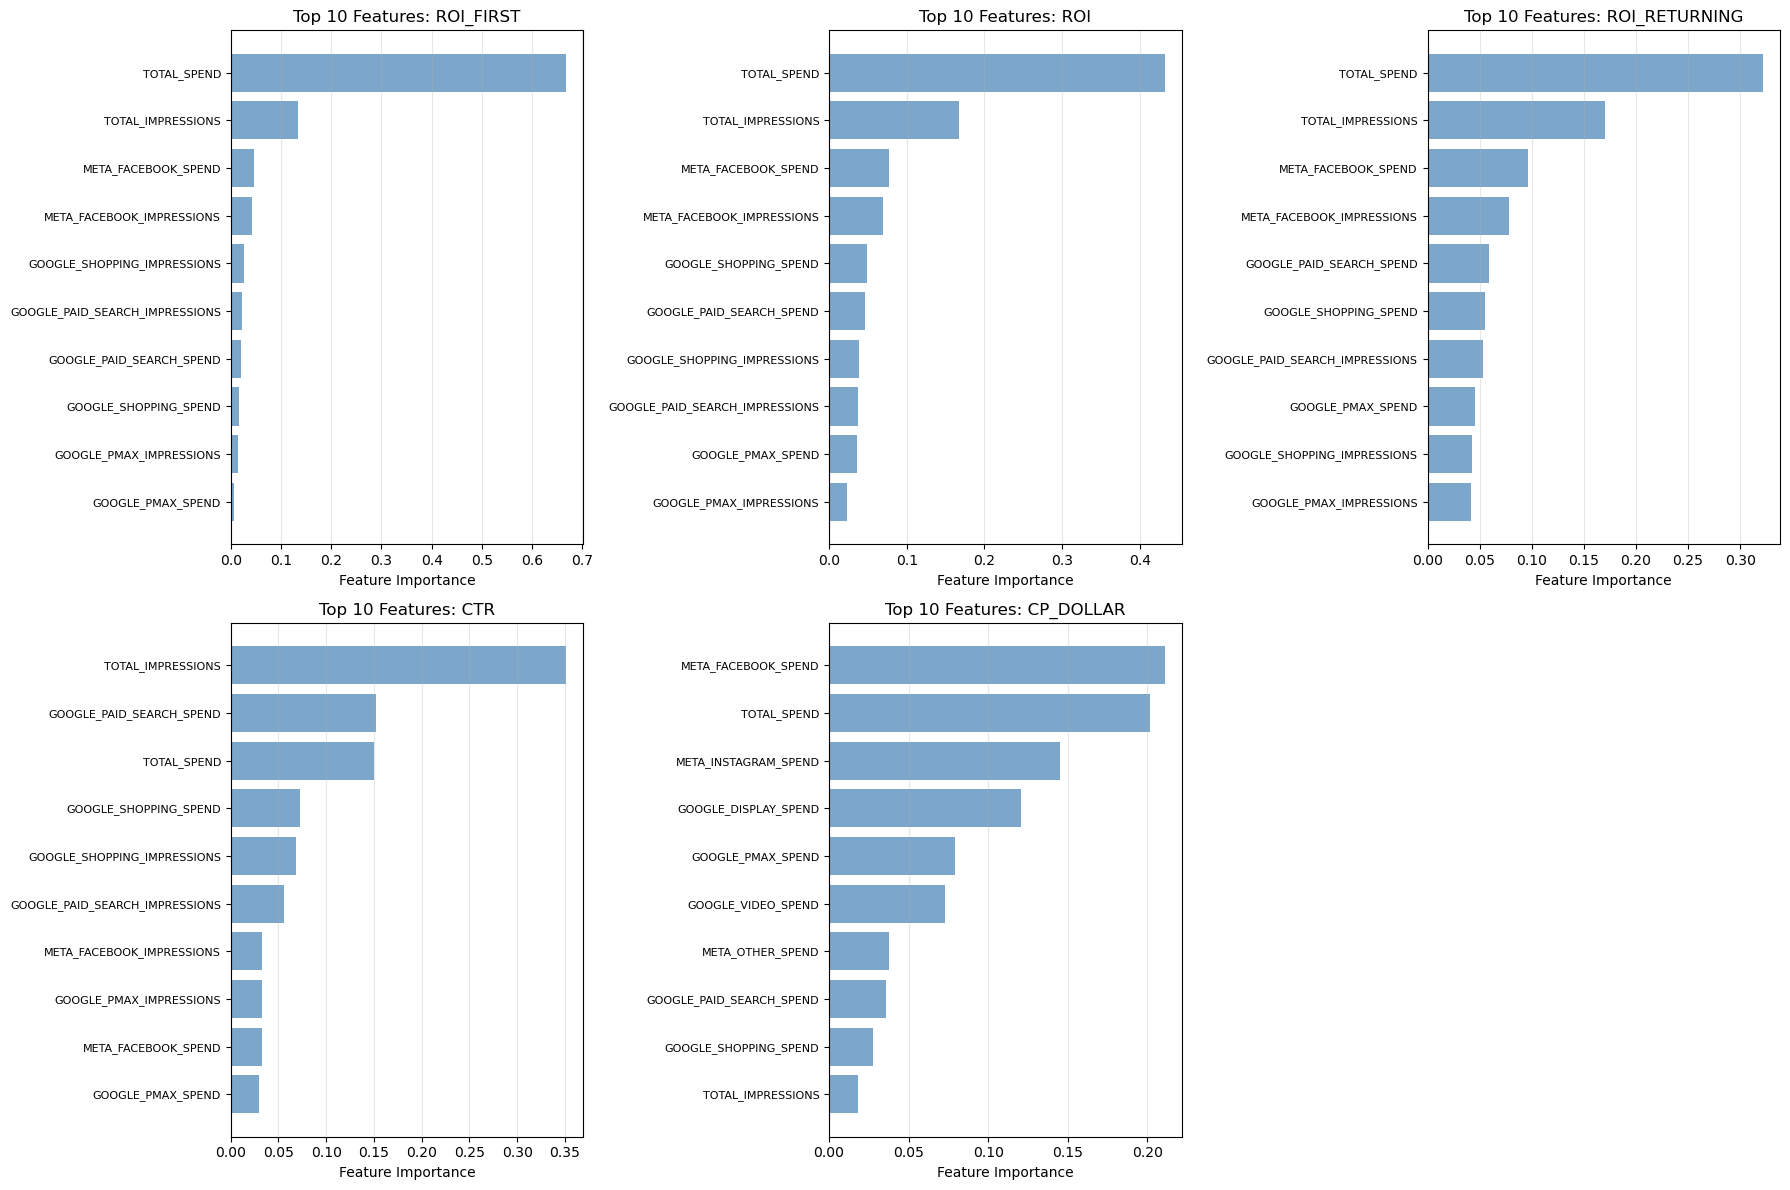

In [15]:
# Feature importance plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

feature_names = X_train.columns

for idx, target in enumerate(target_variables):
    importances = models[target].feature_importances_
    indices = np.argsort(importances)[::-1][:10]  # Top 10 features
    
    axes[idx].barh(range(10), importances[indices], color='steelblue', alpha=0.7)
    axes[idx].set_yticks(range(10))
    axes[idx].set_yticklabels([feature_names[i] for i in indices], fontsize=8)
    axes[idx].set_xlabel('Feature Importance')
    axes[idx].set_title(f'Top 10 Features: {target}')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()


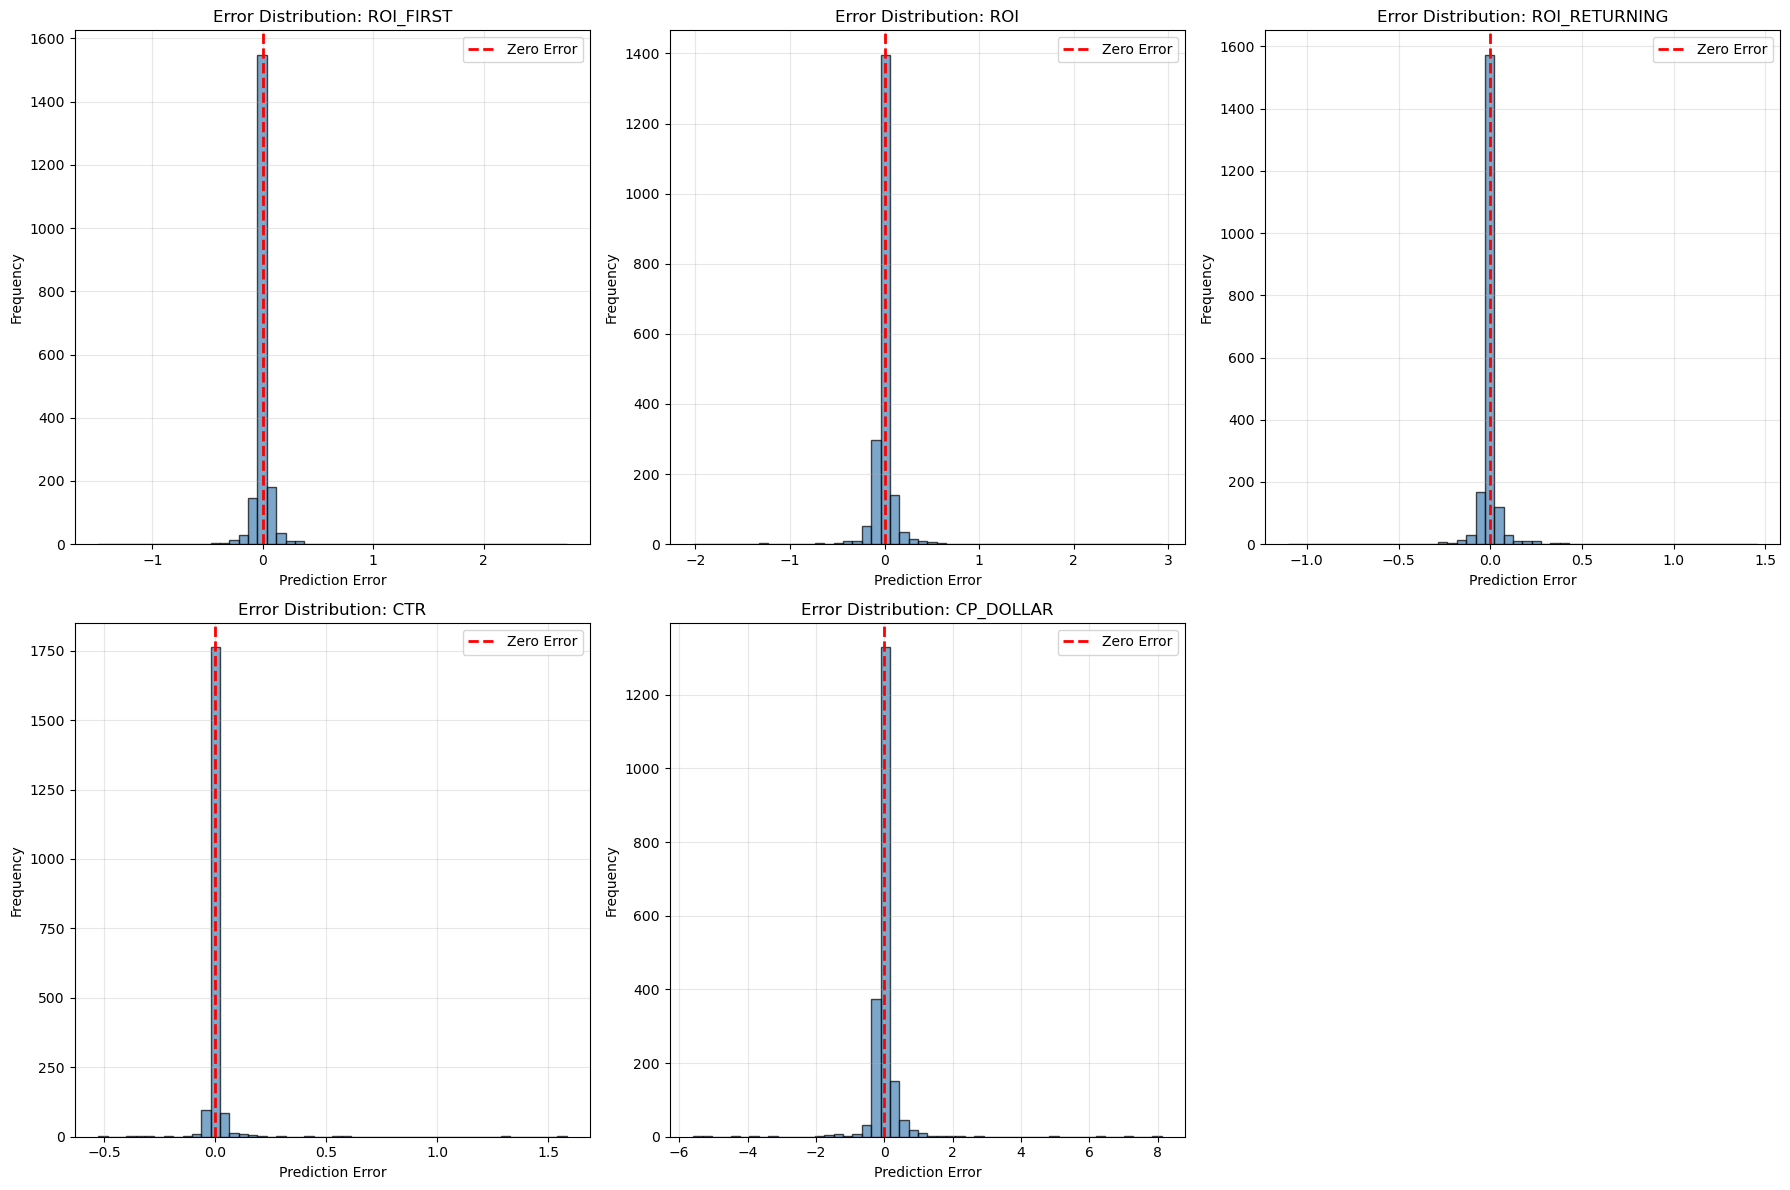

In [16]:
# Error distribution plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, target in enumerate(target_variables):
    y_true = y_test[target]
    y_pred = evaluation_results[target]['predictions']
    errors = y_true - y_pred
    
    # Histogram of errors
    axes[idx].hist(errors, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[idx].axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
    axes[idx].set_xlabel('Prediction Error')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'Error Distribution: {target}')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()


In [17]:
for target in target_variables:
    print(f"\n{target}:")
    for param, value in results[target]['best_params'].items():
        print(f"  {param:20s}: {value}")
    print(f"{'CV MSE':20s}: {results[target]['best_score']:.6f}")



ROI_FIRST:
  max_depth           : None
  max_features        : None
  min_samples_leaf    : 2
  min_samples_split   : 5
  n_estimators        : 100
CV MSE              : 0.017362

ROI:
  max_depth           : 30
  max_features        : sqrt
  min_samples_leaf    : 1
  min_samples_split   : 5
  n_estimators        : 200
CV MSE              : 0.032451

ROI_RETURNING:
  max_depth           : 20
  max_features        : sqrt
  min_samples_leaf    : 1
  min_samples_split   : 2
  n_estimators        : 200
CV MSE              : 0.006914

CTR:
  max_depth           : 30
  max_features        : sqrt
  min_samples_leaf    : 2
  min_samples_split   : 2
  n_estimators        : 100
CV MSE              : 0.003324

CP_DOLLAR:
  max_depth           : None
  max_features        : sqrt
  min_samples_leaf    : 1
  min_samples_split   : 5
  n_estimators        : 100
CV MSE              : 0.318516
